In [ ]:
!pip install transformers==4.31.0 #to fix the Typeerror problem #https://stackoverflow.com/questions/78129126/typeerror-exception-encountered-when-calling-layer-embeddings-type-tfbertemb
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 21.6 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.40.0
    Uninstalling transformers-4.40.0:
      Successfully uninstalled transformers-4.40.0


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, re
warnings.filterwarnings("ignore")
from transformers import AutoTokenizer, AutoModelForMaskedLM, TFBertModel
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPool1D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from google.colab import drive
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

In [ ]:
# Load the CSV file into a DataFrame
file_path = 'https://raw.githubusercontent.com/Letieateat/Sentiment-Analysis-on-Traditional-Chinese-Lyrics/main/dataset/final_sentiments.csv'
df = pd.read_csv(file_path)

# Select only the specific columns
df = df[['final_lyrics', 'human_2']]

# Split the data into three sets: 70%, 15%, and 15%
train, temp = train_test_split(df, test_size=0.3, random_state=42)
val, test = train_test_split(temp, test_size=0.5, random_state=42)

# Rename the 'final_lyrics' column to 'Input' in the DataFrames
train = train.rename(columns={'final_lyrics': 'Input'})
val = val.rename(columns={'final_lyrics': 'Input'})
test = test.rename(columns={'final_lyrics': 'Input'})

# Save the three sets into separate CSV files
train.to_csv('train.csv', index=False)
val.to_csv('val.csv', index=False)
test.to_csv('test.csv', index=False)

##Combining the train, validation and test datasets into a single dataframe

In [ ]:
df = pd.concat([train,val,test],axis=0)
df = df.sample(frac=0.1)
df = df.reset_index()
df.head()

,index,Input,human_2
0,928,開心 先 轉彎 巷 搜尋 前 轉身 左 脫掉 煩惱 得分 最多 換上 快樂 舞步 話 直說 ...,Positive
1,714,夜裡 寂寞 容易 悲傷 敢 想 太多 迎面 月光 拉長 身影 漫無 目的 走 冷冷 街 妳 ...,Negative
2,186,明天 想起 昨天 寫 日記 明天 惦記 曾經 最愛 哭 老師 想 猜 出 問題 偶然 翻 相...,Positive
3,732,敢 問 一直 想 問 心 裡 藏 敢 猜 一直 想 猜 回去 可能 夠 完整 從來 夠 完整...,Negative
4,469,沒 好好 感受 雪花 綻放 氣候 一起 顫抖 明白 溫柔 沒 牽 手 走過 荒蕪 沙丘 可能...,Positive


In [ ]:
df.drop('index',axis=1,inplace=True)

In [ ]:
df.shape

(100, 2)

In [ ]:
df['num_words'] = df.Input.apply(len)

In [ ]:
df.head()

,Input,human_2,num_words
0,開心 先 轉彎 巷 搜尋 前 轉身 左 脫掉 煩惱 得分 最多 換上 快樂 舞步 話 直說 ...,Positive,110
1,夜裡 寂寞 容易 悲傷 敢 想 太多 迎面 月光 拉長 身影 漫無 目的 走 冷冷 街 妳 ...,Negative,85
2,明天 想起 昨天 寫 日記 明天 惦記 曾經 最愛 哭 老師 想 猜 出 問題 偶然 翻 相...,Positive,102
3,敢 問 一直 想 問 心 裡 藏 敢 猜 一直 想 猜 回去 可能 夠 完整 從來 夠 完整...,Negative,120
4,沒 好好 感受 雪花 綻放 氣候 一起 顫抖 明白 溫柔 沒 牽 手 走過 荒蕪 沙丘 可能...,Positive,109


In [ ]:
encoded_labels = {'Negative': 0, 'Positive': 1}

##Text Tokenization

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-chinese")
bert_model = TFBertModel.from_pretrained("bert-base-chinese")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/269k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/412M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
X_train = tokenizer(text=train.Input.tolist(),
                   add_special_tokens=True,
                   return_tensors='tf',
                   #max_length=max_len,
                   padding=True,
                   truncation=True,
                   return_token_type_ids=False,
                   return_attention_mask=True,
                   verbose=True
                   )

X_val = tokenizer(text=val.Input.tolist(),
                  add_special_tokens=True,
                  return_tensors='tf',
                  #max_length=max_len,
                  padding=True,
                  truncation=True,
                  return_token_type_ids=False,
                  return_attention_mask=True,
                  verbose=True
                 )

X_test = tokenizer(text=test.Input.tolist(),
                   add_special_tokens=True,
                   return_tensors='tf',
                   #max_length=max_len,
                   padding=True,
                   truncation=True,
                   return_token_type_ids=False,
                   return_attention_mask=True,
                   verbose=True
                  )

##Defining the model architecture

In [ ]:
input_ids = Input(shape=(None,),name='input_ids',dtype=tf.int32)
attention_mask = Input(shape=(None,),name='attention_mask',dtype=tf.int32)

In [ ]:
embeddings = bert_model(input_ids,attention_mask=attention_mask)[0] # 0: final hidden state, 1: pooling output
output = GlobalMaxPool1D()(embeddings)
output = Dense(units=128,activation='relu')(output)
output = Dropout(0.1)(output)
output = Dense(units=64,activation='relu')(output)
output = Dense(units=32,activation='relu')(output)
y = Dense(units=2,activation='softmax')(output)

model = Model(inputs=[input_ids,attention_mask],outputs=y)
model.layers[2].trainable = True

##Encoding the emotion labels

In [ ]:
train['Label'] = train.human_2.map(encoded_labels)
val['Label'] = val.human_2.map(encoded_labels)
test['Label'] = test.human_2.map(encoded_labels)

In [ ]:
train.head()

,Input,human_2,Label
440,相約 來到 世上 途中 失散 走 路 片 豔陽 忽然 預感 久違 陌生人 遇上 也許 笑 弧...,Positive,1
482,朋友 沒 笑 夢 種 安慰 不會 痛 放棄 理由 理直氣壯 背後 惶恐 世界 缺 偉大 成功...,Negative,0
422,天 想 信任 樣子 信任 臉 畫 艷麗 粧 眼神 天真 信任 其實 抽絲剝繭 詮釋 深入淺出...,Positive,1
780,愛 愛 心 滿 傷痕 犯 犯 錯 心 滿 悔恨 嚐盡 生活 苦 找 相信 感到 萬分 沮喪 ...,Negative,0
951,正在 休息 路 問 接下來 幹嘛 沙灘 大海 森林 清爽 沒關係 感覺 執著 想要 快 不要...,Positive,1


In [ ]:
test.head()

,Input,human_2,Label
259,知道 明偉 重量 平凡 擁有 無限 幻想 好像 很多 樣 好像 很多 你我 樣端 懂 抬 價...,Positive,1
858,次 徘徊 孤單 堅強 次 受傷 閃 淚光 知道 一直 雙 隱形 翅膀 帶 飛飛 絕望 想 擁...,Positive,1
906,撲火 相視 笑 撲火 真 相視 笑 夢 快樂 穿越 愛 歷史 走來 眼 裡 看盡 相戀 年代...,Positive,1
615,到底 笑 虛偽 能夠 融入 世界 臉 貼 張 假面 想 想 想 想 靈魂 深處 到底 發生 ...,Negative,0
296,寄 地址 信 情緒 有種 距離 放 歌曲 心情 能不能 聽 雨 安靜 偷偷 哭泣 幸福 真的...,Negative,0


##Training and fine-tuning the pretrained BERT model

##Finding the best learning rate

Training with learning rate: 1e-05
Epoch 1/5


22/22 [==============================] - 80s 2s/step - loss: 0.4740 - categorical_accuracy: 0.7675 - val_loss: 0.4226 - val_categorical_accuracy: 0.8267
Epoch 2/5
22/22 [==============================] - 30s 1s/step - loss: 0.3385 - categorical_accuracy: 0.8645 - val_loss: 0.4221 - val_categorical_accuracy: 0.8000
Epoch 3/5
22/22 [==============================] - 31s 1s/step - loss: 0.2621 - categorical_accuracy: 0.9016 - val_loss: 0.4711 - val_categorical_accuracy: 0.8133
Epoch 4/5
22/22 [==============================] - 31s 1s/step - loss: 0.1635 - categorical_accuracy: 0.9544 - val_loss: 0.5065 - val_categorical_accuracy: 0.8067
Epoch 5/5
22/22 [==============================] - 31s 1s/step - loss: 0.1108 - categorical_accuracy: 0.9615 - val_loss: 0.6482 - val_categorical_accuracy: 0.8000
Training with learning rate: 3e-05
Epoch 1/5


22/22 [==============================] - 79s 2s/step - loss: 0.7449 - categorical_accuracy: 0.6120 - val_loss: 0.6736 - val_categorical_accuracy: 0.5600
Epoch 2/5
22/22 [==============================] - 31s 1s/step - loss: 0.4864 - categorical_accuracy: 0.7703 - val_loss: 0.5416 - val_categorical_accuracy: 0.7600
Epoch 3/5
22/22 [==============================] - 32s 1s/step - loss: 0.3118 - categorical_accuracy: 0.8902 - val_loss: 0.5193 - val_categorical_accuracy: 0.7733
Epoch 4/5
22/22 [==============================] - 32s 1s/step - loss: 0.1799 - categorical_accuracy: 0.9486 - val_loss: 0.5998 - val_categorical_accuracy: 0.7667
Epoch 5/5
22/22 [==============================] - 32s 1s/step - loss: 0.1349 - categorical_accuracy: 0.9486 - val_loss: 0.7318 - val_categorical_accuracy: 0.7800
Training with learning rate: 5e-05
Epoch 1/5


22/22 [==============================] - 79s 2s/step - loss: 0.6928 - categorical_accuracy: 0.7261 - val_loss: 0.6642 - val_categorical_accuracy: 0.7600
Epoch 2/5
22/22 [==============================] - 32s 1s/step - loss: 0.2751 - categorical_accuracy: 0.8973 - val_loss: 0.6839 - val_categorical_accuracy: 0.7533
Epoch 3/5
22/22 [==============================] - 32s 1s/step - loss: 0.0999 - categorical_accuracy: 0.9729 - val_loss: 1.0549 - val_categorical_accuracy: 0.7133
Epoch 4/5
22/22 [==============================] - 32s 1s/step - loss: 0.1082 - categorical_accuracy: 0.9643 - val_loss: 0.7431 - val_categorical_accuracy: 0.7733
Epoch 5/5
22/22 [==============================] - 32s 1s/step - loss: 0.0556 - categorical_accuracy: 0.9815 - val_loss: 0.9737 - val_categorical_accuracy: 0.7467


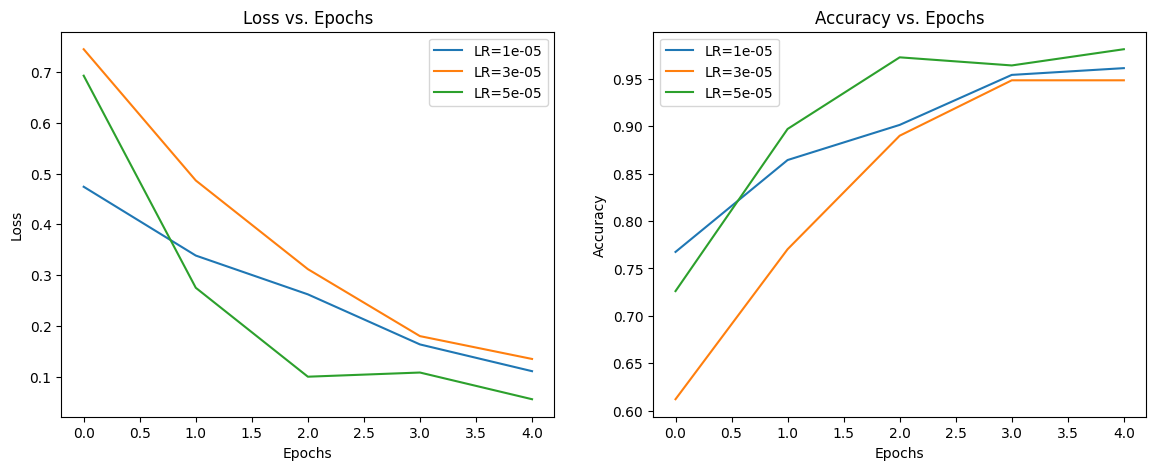

In [ ]:
learning_rates = [1e-5, 3e-5, 5e-5]
loss_history = []
accuracy_history = []

for lr in learning_rates:
    print(f"Training with learning rate: {lr}")
    lr_schedule = ExponentialDecay(
        initial_learning_rate=lr,
        decay_steps=100000,
        decay_rate=0.96,
        staircase=True)

    optimizer = Adam(learning_rate=lr_schedule, epsilon=1e-8, clipnorm=1.0)
    model.compile(
        loss=CategoricalCrossentropy(from_logits=True),
        optimizer=optimizer,
        metrics=[CategoricalAccuracy()]
    )

    # training
    history = model.fit(
        x={'input_ids': X_train['input_ids'], 'attention_mask': X_train['attention_mask']},
        y=to_categorical(train.Label, num_classes=2),
        epochs=5,
        batch_size=32,
        verbose=1,
        validation_data=(
            {'input_ids': X_val['input_ids'], 'attention_mask': X_val['attention_mask']},
            to_categorical(val.Label, num_classes=2)
        )
    )

    # save the results
    loss_history.append(history.history['loss'])
    accuracy_history.append(history.history['categorical_accuracy'])

### plot the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
for i, lr in enumerate(learning_rates):
    ax1.plot(loss_history[i], label=f"LR={lr}")
    ax2.plot(accuracy_history[i], label=f"LR={lr}")

ax1.set_title('Loss vs. Epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.set_title('Accuracy vs. Epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()